In [2]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, GroupNormalizer
from lightning.pytorch.tuner import Tuner
import torch
from pytorch_forecasting.metrics import MAE
import pandas as pd

In [12]:
data = pd.read_csv('Merged_Final.csv')

In [13]:
data.head()

,Date,LTC_Price,LTC_Volume,ETH_Price,ETH_Volume,BTC_Price,BTC_Volume,Gold_Price,Interest_Rate,VIX_Close
0,2019-08-28,0.102652,0.154545,0.013460,0.056006,0.070231,0.035507,0.079985,0.393195,0.109768
1,2019-08-29,0.093292,0.166255,0.012530,0.061260,0.066646,0.033893,0.071482,0.393195,0.089108
2,2019-08-30,0.093953,0.126259,0.012385,0.044840,0.067937,0.023910,0.064474,0.395085,0.104568
3,2019-08-31,0.094637,0.120992,0.013158,0.045492,0.068414,0.017717,0.064474,0.395085,0.104568
4,2019-09-01,0.099049,0.117904,0.012980,0.042150,0.070283,0.017690,0.064474,0.395085,0.104568


In [14]:
print(data.columns)

Index(['Date', 'LTC_Price', 'LTC_Volume', 'ETH_Price', 'ETH_Volume',
       'BTC_Price', 'BTC_Volume', 'Gold_Price', 'Interest_Rate', 'VIX_Close'],
      dtype='object')


In [15]:
# Melt price data
data_melted = data.melt(
    id_vars=['Date', 'Gold_Price', 'Interest_Rate', 'VIX_Close'],
    value_vars=['LTC_Price', 'ETH_Price', 'BTC_Price'],
    var_name='currency_type',
    value_name='price'
)

In [16]:
# Melt volume data
volume_melted = data.melt(
    id_vars=['Date', 'Gold_Price', 'Interest_Rate', 'VIX_Close'],
    value_vars=['LTC_Volume', 'ETH_Volume', 'BTC_Volume'],
    var_name='currency_type',
    value_name='volume'
)

In [17]:
# Standardize currency_type column
data_melted['currency_type'] = data_melted['currency_type'].str.replace('_Price', '')
volume_melted['currency_type'] = volume_melted['currency_type'].str.replace('_Volume', '')

In [18]:
# Merge price and volume data
merged_data = pd.merge(
    data_melted, volume_melted,
    on=['Date', 'currency_type', 'Gold_Price', 'Interest_Rate', 'VIX_Close']
)

# Sort by date and currency type
merged_data = merged_data.sort_values(by=['Date', 'currency_type']).reset_index(drop=True)

In [25]:
merged_data.head()

,Date,Gold_Price,Interest_Rate,VIX_Close,currency_type,price,volume
0,2019-08-28,0.079985,0.393195,0.109768,BTC,0.070231,0.035507
1,2019-08-28,0.079985,0.393195,0.109768,ETH,0.013460,0.056006
2,2019-08-28,0.079985,0.393195,0.109768,LTC,0.102652,0.154545
3,2019-08-29,0.071482,0.393195,0.089108,BTC,0.066646,0.033893
4,2019-08-29,0.071482,0.393195,0.089108,ETH,0.012530,0.061260


In [26]:
# convert columns datatypes into appropriate data types
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data['currency_type'] = merged_data['currency_type'].astype(str).astype("category")

In [27]:
merged_data.dtypes

Date             datetime64[ns]
Gold_Price              float64
Interest_Rate           float64
VIX_Close               float64
currency_type          category
price                   float64
volume                  float64
dtype: object

In [28]:
# add additional features
import numpy as np

merged_data["month"] = merged_data.Date.dt.month.astype(str).astype("category")  # categories have be strings
merged_data["day_of_week"] = merged_data.Date.dt.dayofweek.astype(str).astype("category")
merged_data["day_of_year"] = merged_data.Date.dt.dayofyear.astype(str).astype("category")
merged_data["quarter"] = merged_data.Date.dt.quarter.astype(str).astype("category")  # categories have be strings

merged_data["log_price"] = np.log(merged_data.price + 1e-8)

In [49]:
merged_data.head()

,Date,Gold_Price,Interest_Rate,VIX_Close,currency_type,price,volume,month,day_of_week,day_of_year,quarter,log_price,time_idx
0,2019-08-28,0.079985,0.393195,0.109768,BTC,0.070231,0.035507,8,2,240,3,-2.655965,0
1,2019-08-28,0.079985,0.393195,0.109768,ETH,0.013460,0.056006,8,2,240,3,-4.307998,0
2,2019-08-28,0.079985,0.393195,0.109768,LTC,0.102652,0.154545,8,2,240,3,-2.276415,0
3,2019-08-29,0.071482,0.393195,0.089108,BTC,0.066646,0.033893,8,3,241,3,-2.708360,1
4,2019-08-29,0.071482,0.393195,0.089108,ETH,0.012530,0.061260,8,3,241,3,-4.379607,1


In [48]:
# Define dataset parameters
merged_data["time_idx"] = (merged_data["Date"] - merged_data["Date"].min()).dt.days

In [50]:
max_prediction_length = 30  # Set to desired prediction length
max_encoder_length = 90  # Set to desired history length (e.g., 30 days) - pass 30 days are used to predict next 7 days
batch_size = 64
training_cutoff = merged_data['time_idx'].max() - max_prediction_length

In [68]:
training = TimeSeriesDataSet(
    merged_data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="price",
    group_ids=["currency_type"],  # Use "id" as the group identifier
    max_encoder_length=max_encoder_length // 2,
    max_prediction_length=max_prediction_length,
    static_categoricals=["currency_type"],
    time_varying_known_categoricals=["month", "day_of_week", "day_of_year", "quarter"],
    static_reals=[],  # Add any static features if available
    time_varying_known_reals=["time_idx", "Gold_Price", "Interest_Rate", "VIX_Close"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["price", "log_price", "volume"],
    target_normalizer=GroupNormalizer(groups=["currency_type"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [69]:
validation = TimeSeriesDataSet.from_dataset(training, merged_data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)

In [70]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [71]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",  # run on CPU, if on multiple GPUs, use strategy="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [72]:
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.003,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 101.4k


c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minim

You are using a CUDA device ('NVIDIA GeForce RTX 2050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connec

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:770: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0080709710815976
Restoring states from the checkpoint path at c:\Users\Sathmika\Desktop\FYP\cryptoCurrencyPricePredictionTFT\cryptoCurrencyPricePredictionTFT\final\.lr_find_e945072b-9295-42f7-88b2-758753313c17.ckpt
Restored all states from the checkpoint at c:\Users\Sathmika\Desktop\FYP\cryptoCurrencyPricePredictionTFT\cryptoCurrencyPricePredictionTFT\final\.lr_find_e945072b-9295-42f7-88b2-758753313c17.ckpt


suggested learning rate: 0.0080709710815976


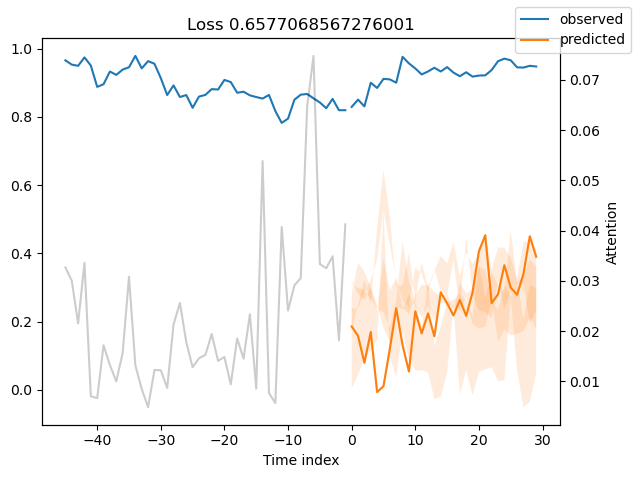

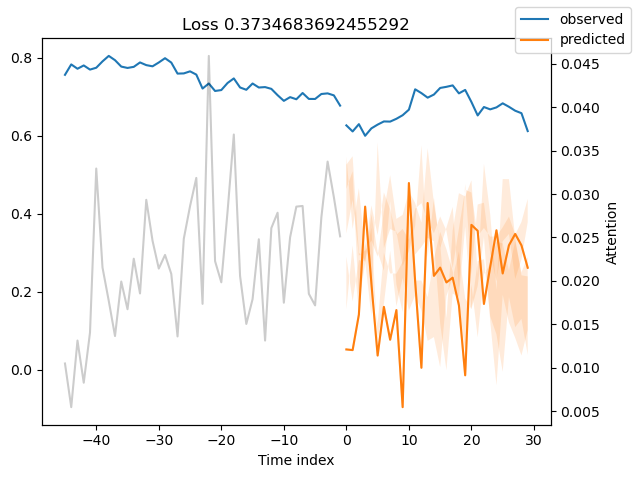

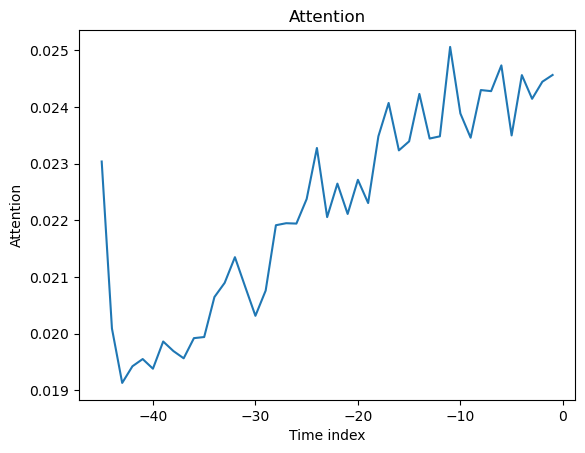

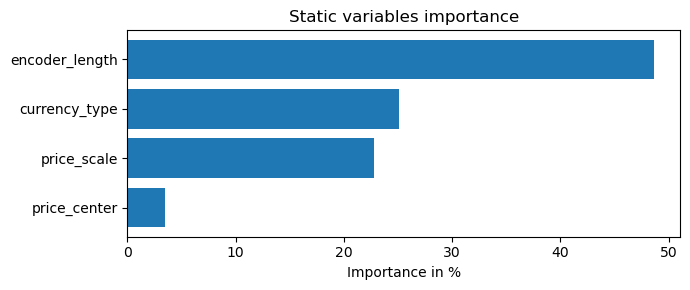

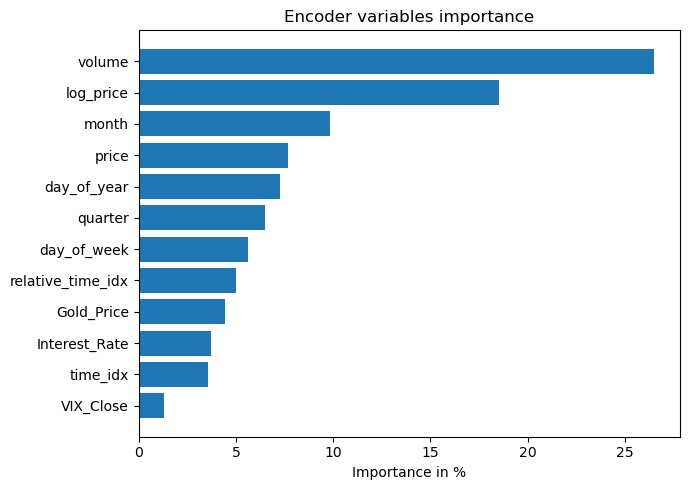

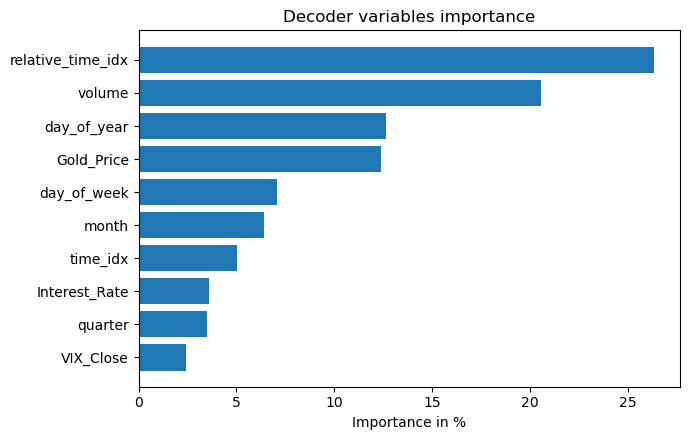

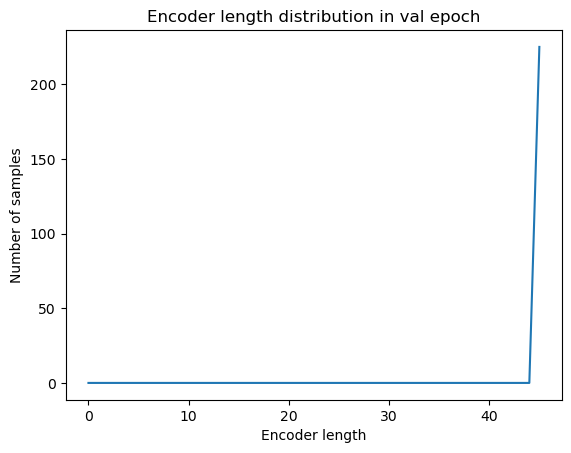

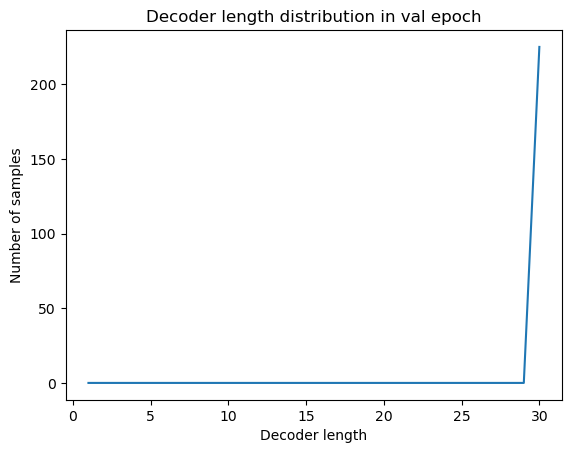

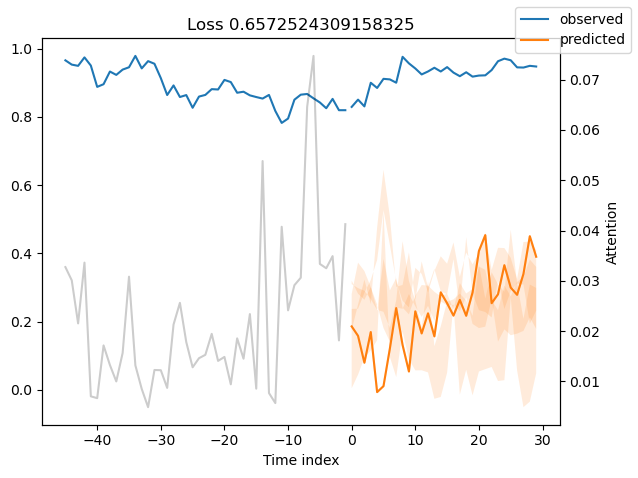

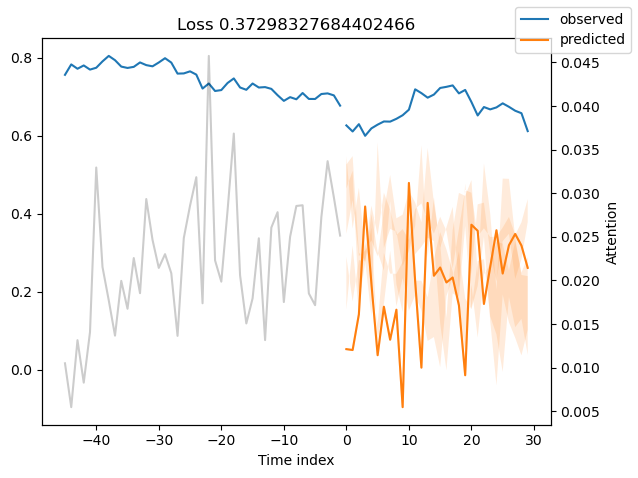

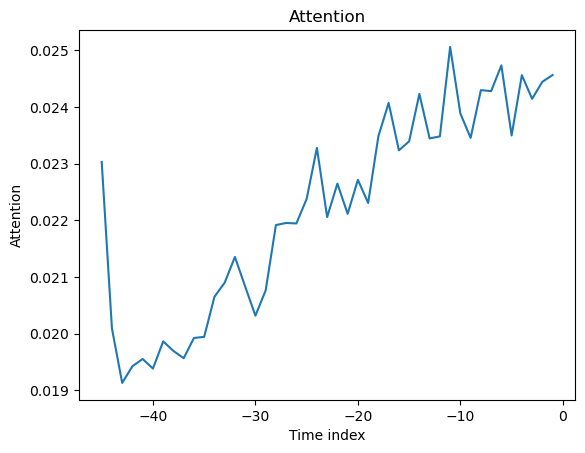

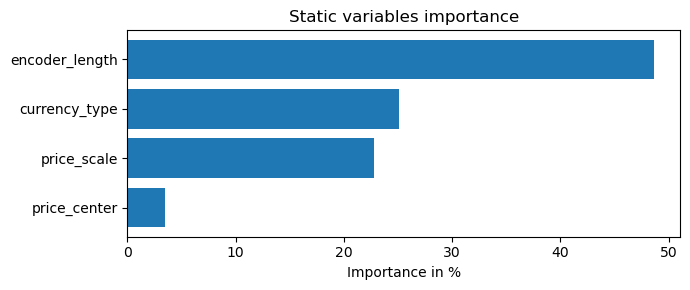

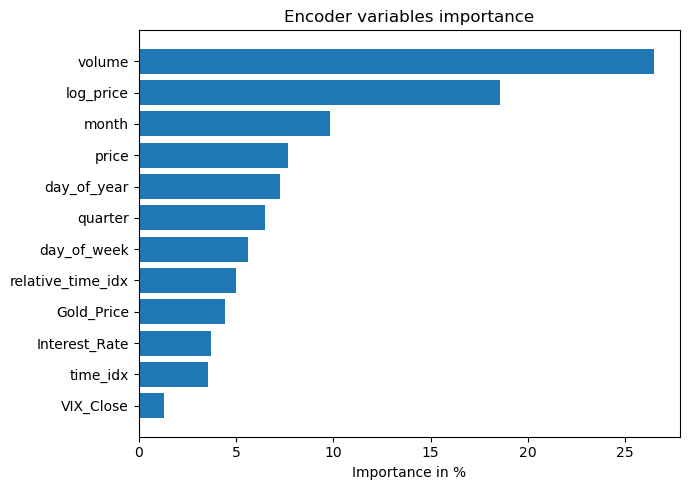

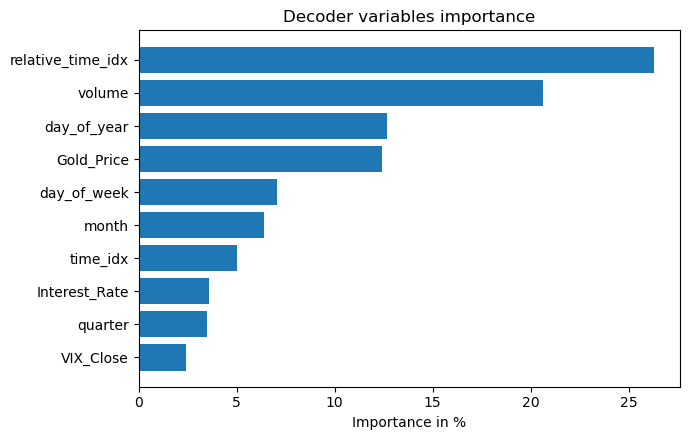

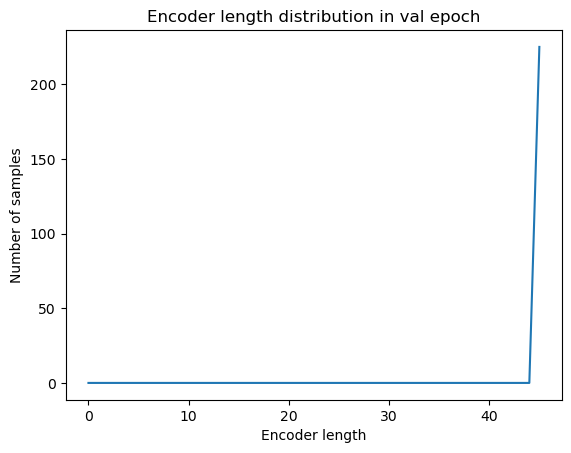

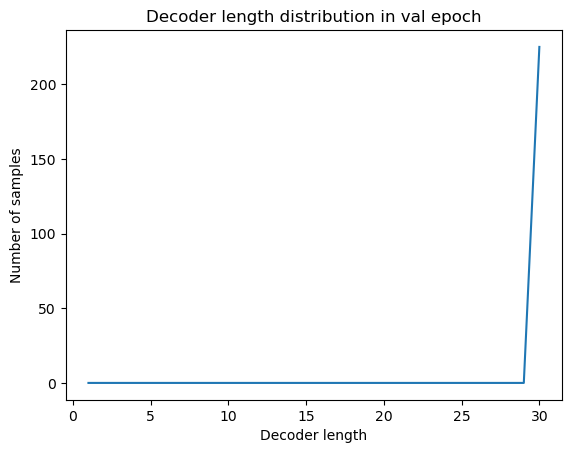

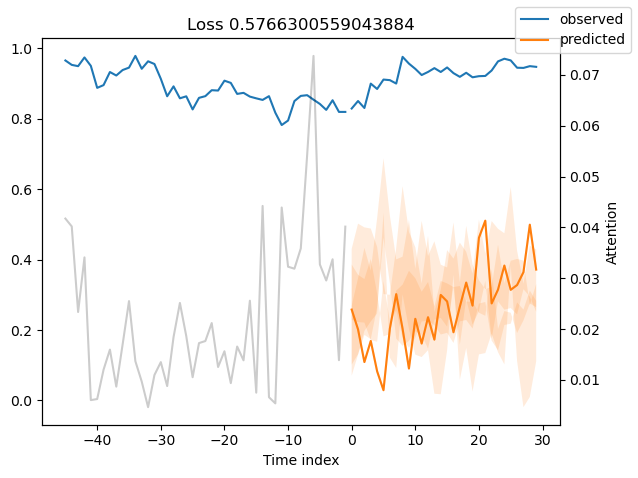

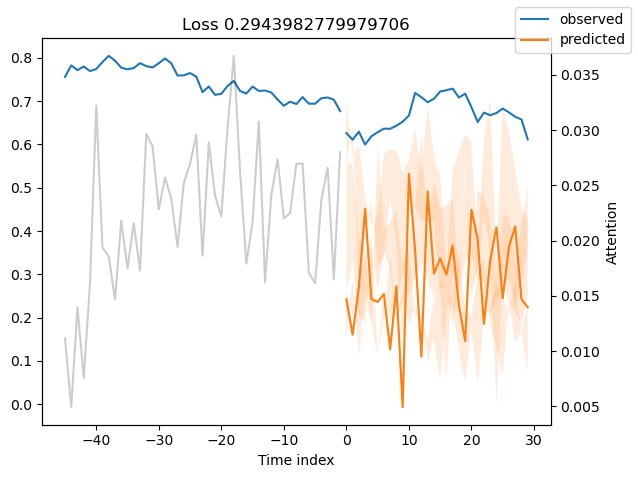

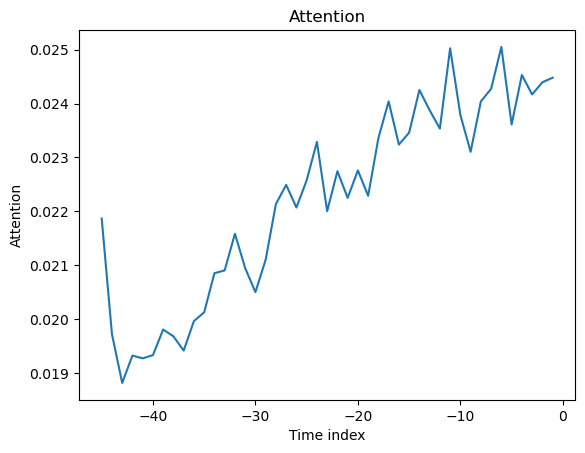

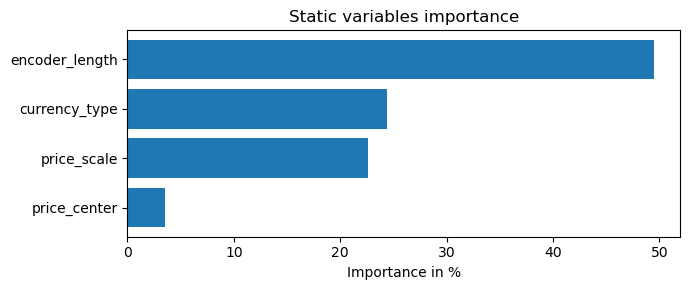

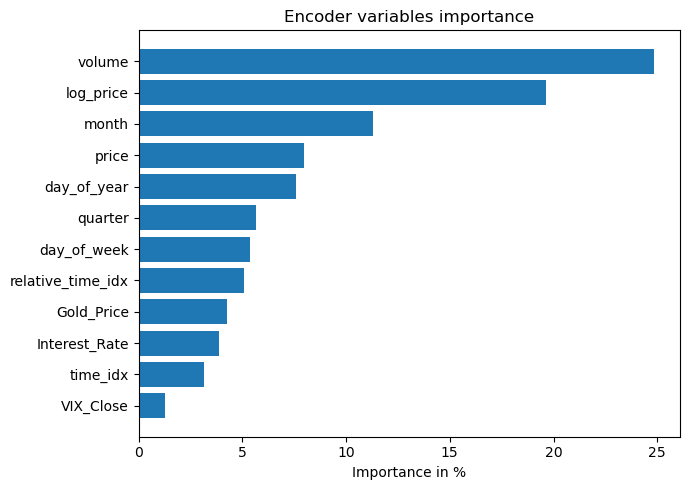

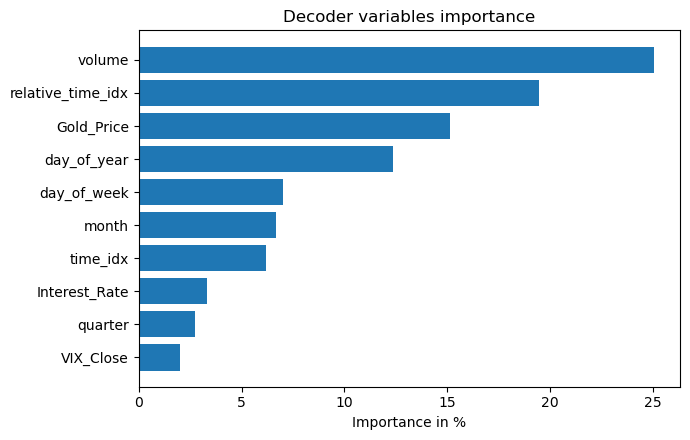

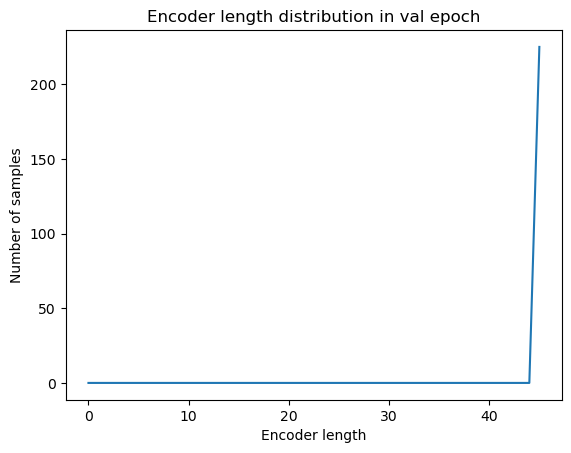

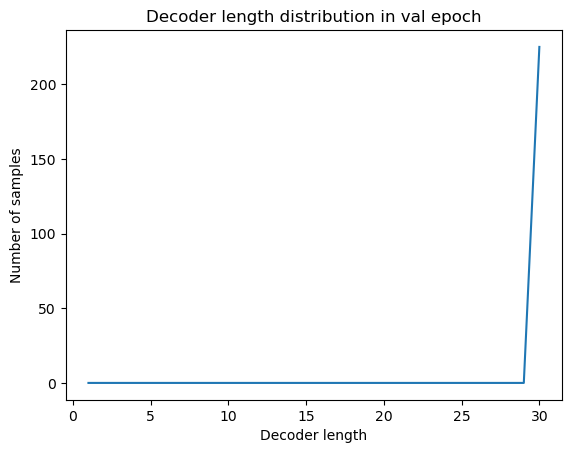

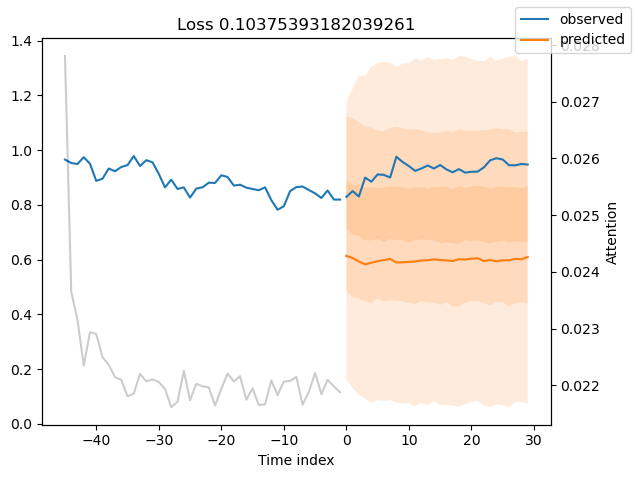

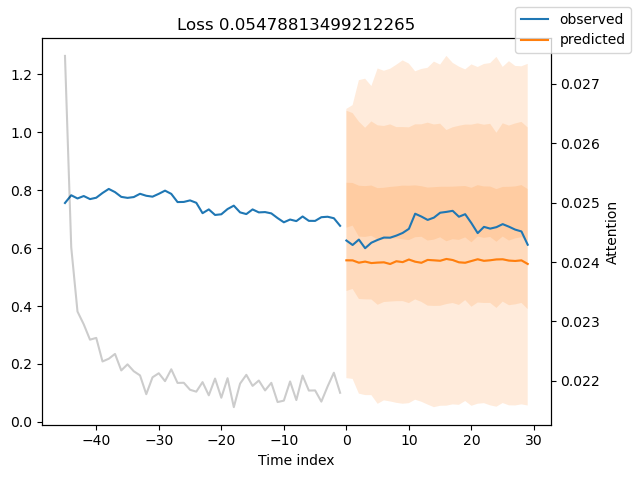

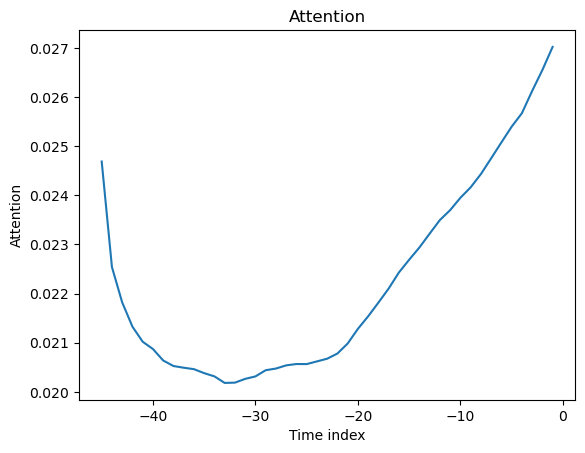

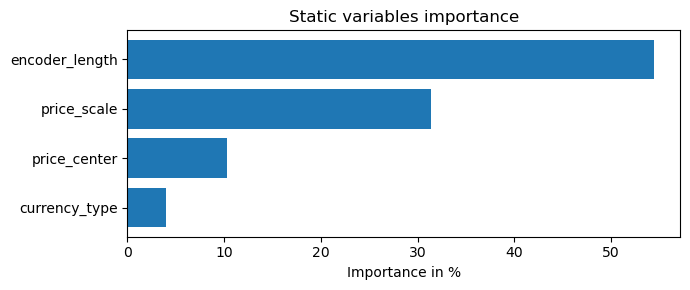

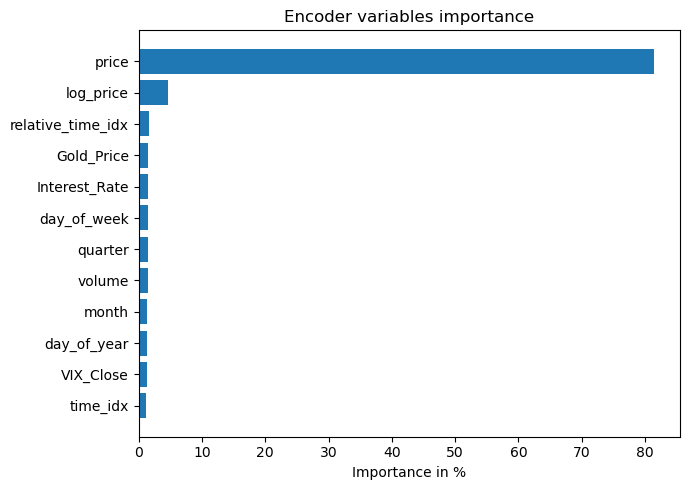

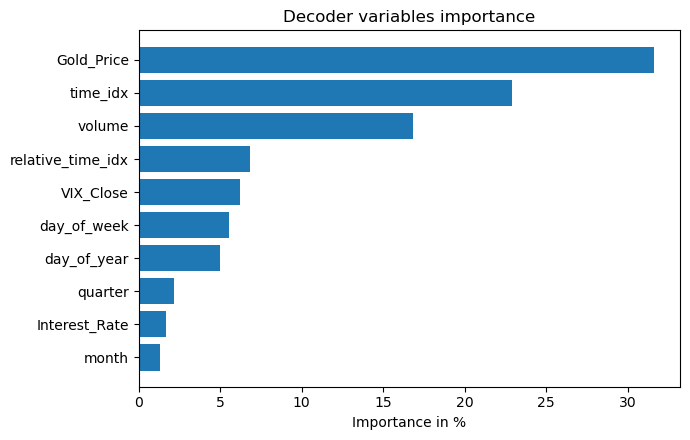

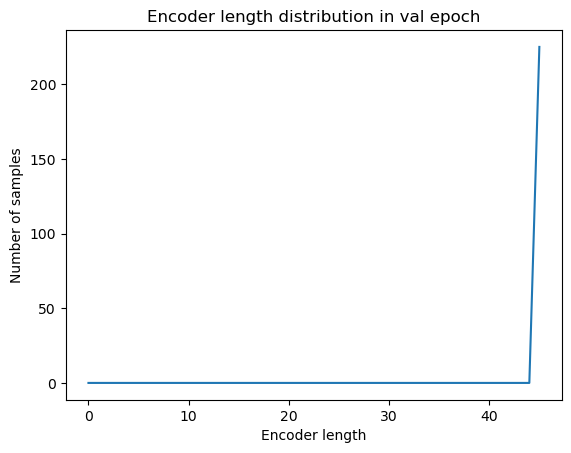

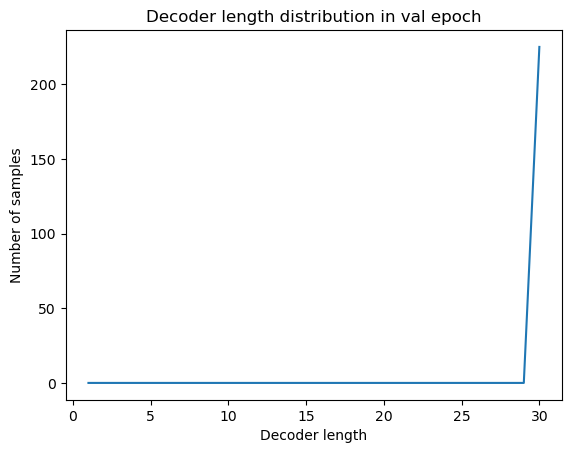

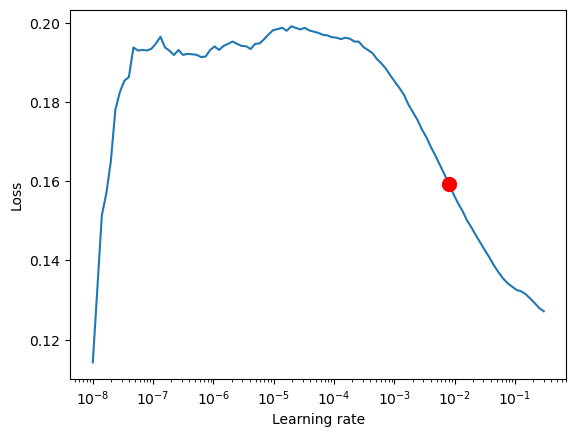

C:\Users\Sathmika\AppData\Local\Temp\ipykernel_17796\1371792773.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [56]:
# find the optimal learning rate
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)
# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [73]:
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 11.8 K | train
3  | prescalers                         | ModuleDict                      | 352    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 18.0 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 11.2 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [74]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [75]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


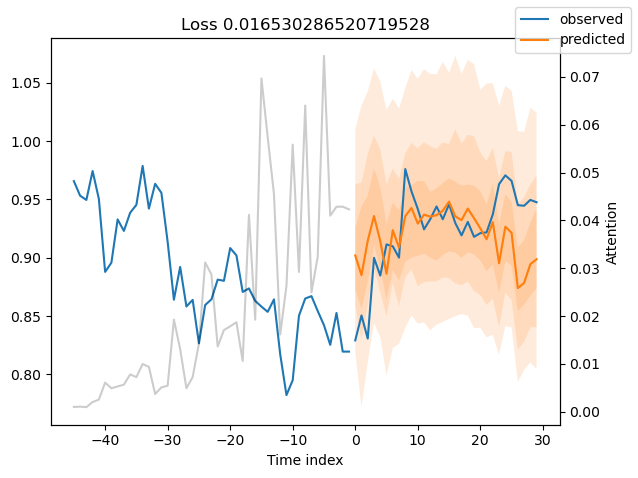

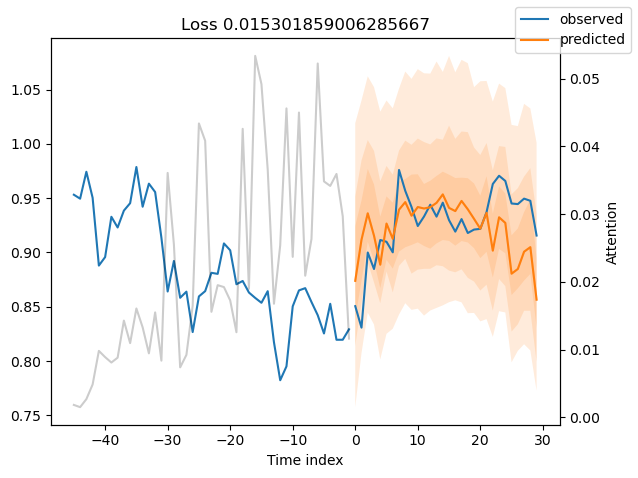

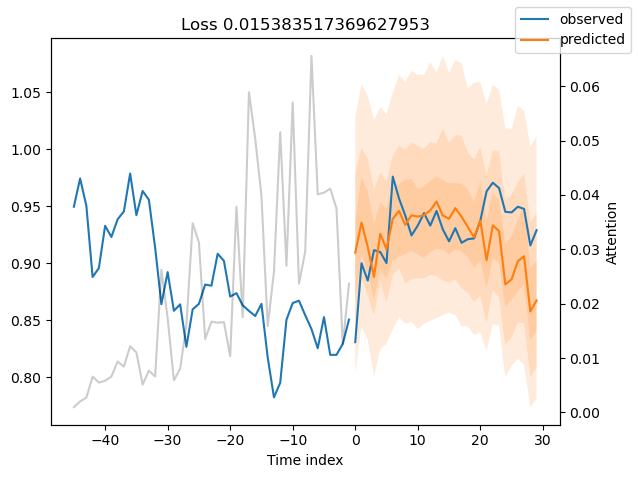

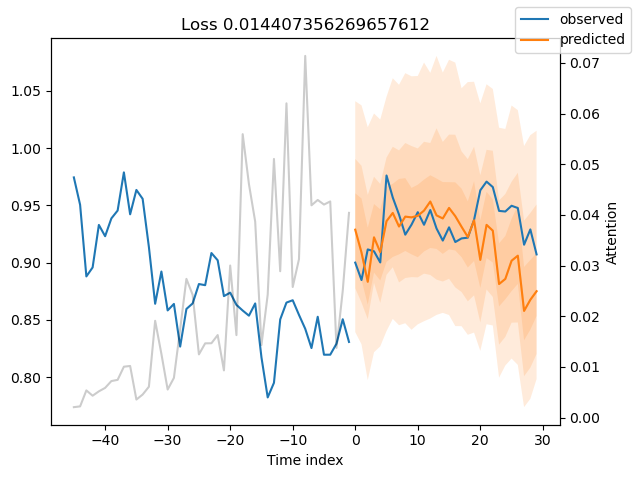

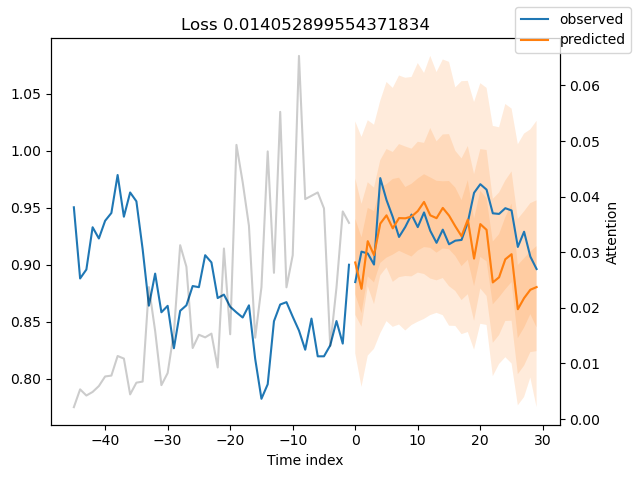

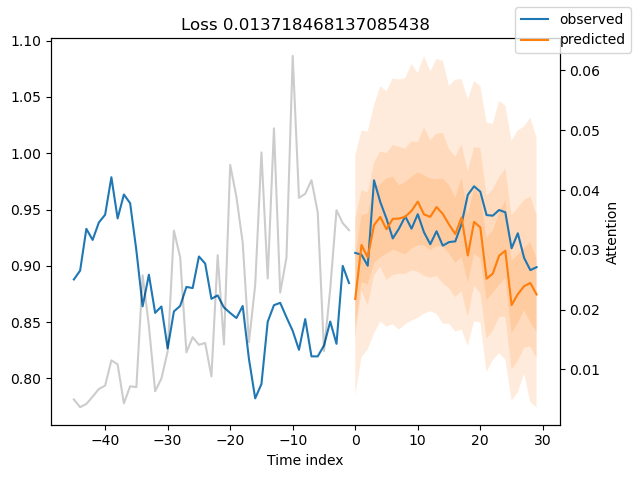

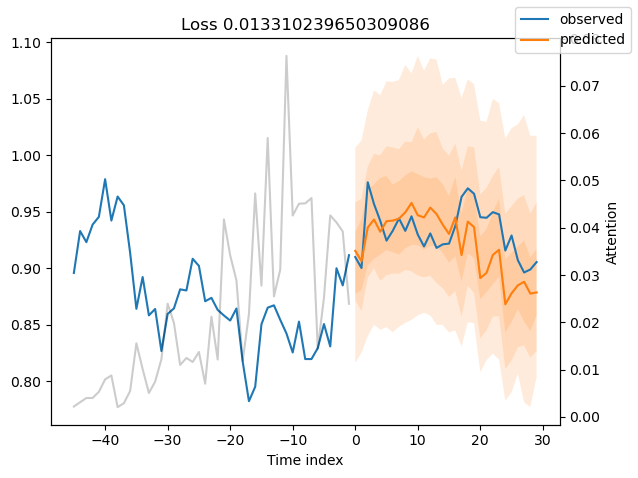

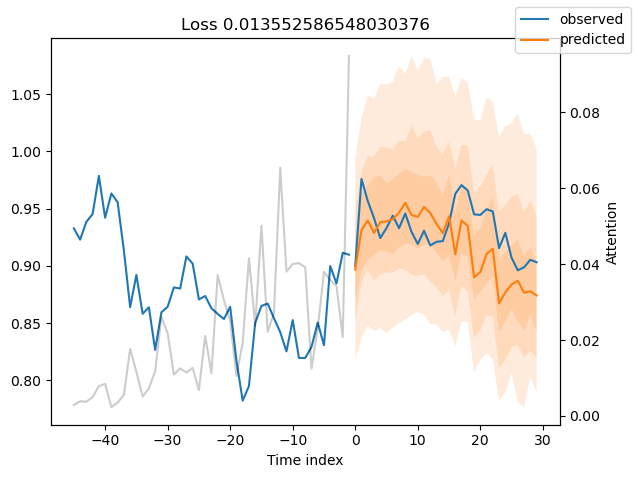

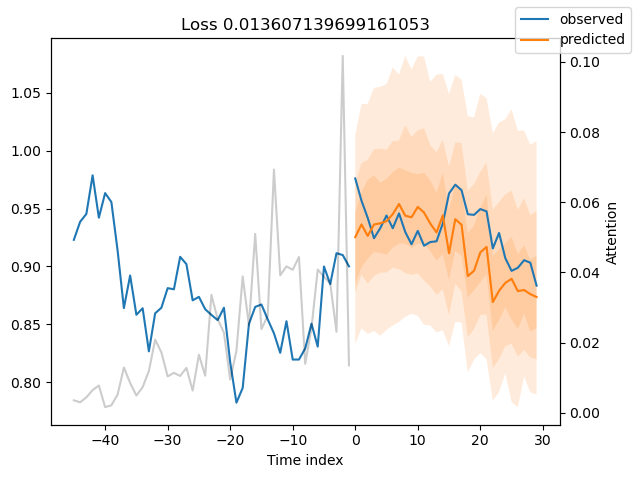

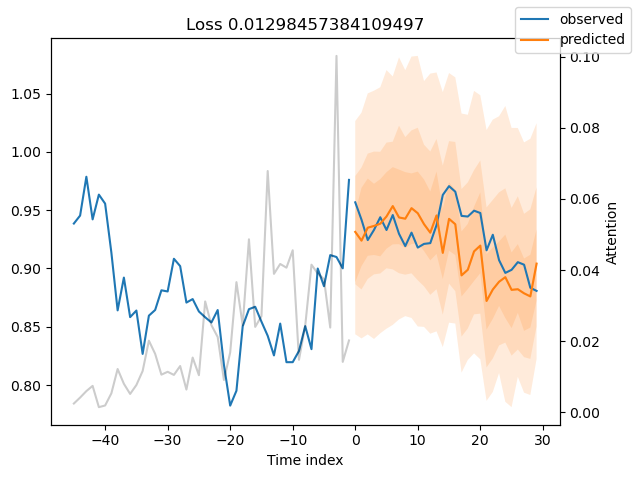

In [76]:
# Access the predictions from the named tuple
predictions_tensor = raw_predictions.output.prediction

# Get the number of available predictions (first dimension of the tensor)
num_predictions = predictions_tensor.size(0)

# Adjust loop to avoid out-of-bounds error
for idx in range(min(10, num_predictions)):  # Only iterate over available predictions
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [77]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation MAE: 0.03558759391307831


In [78]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


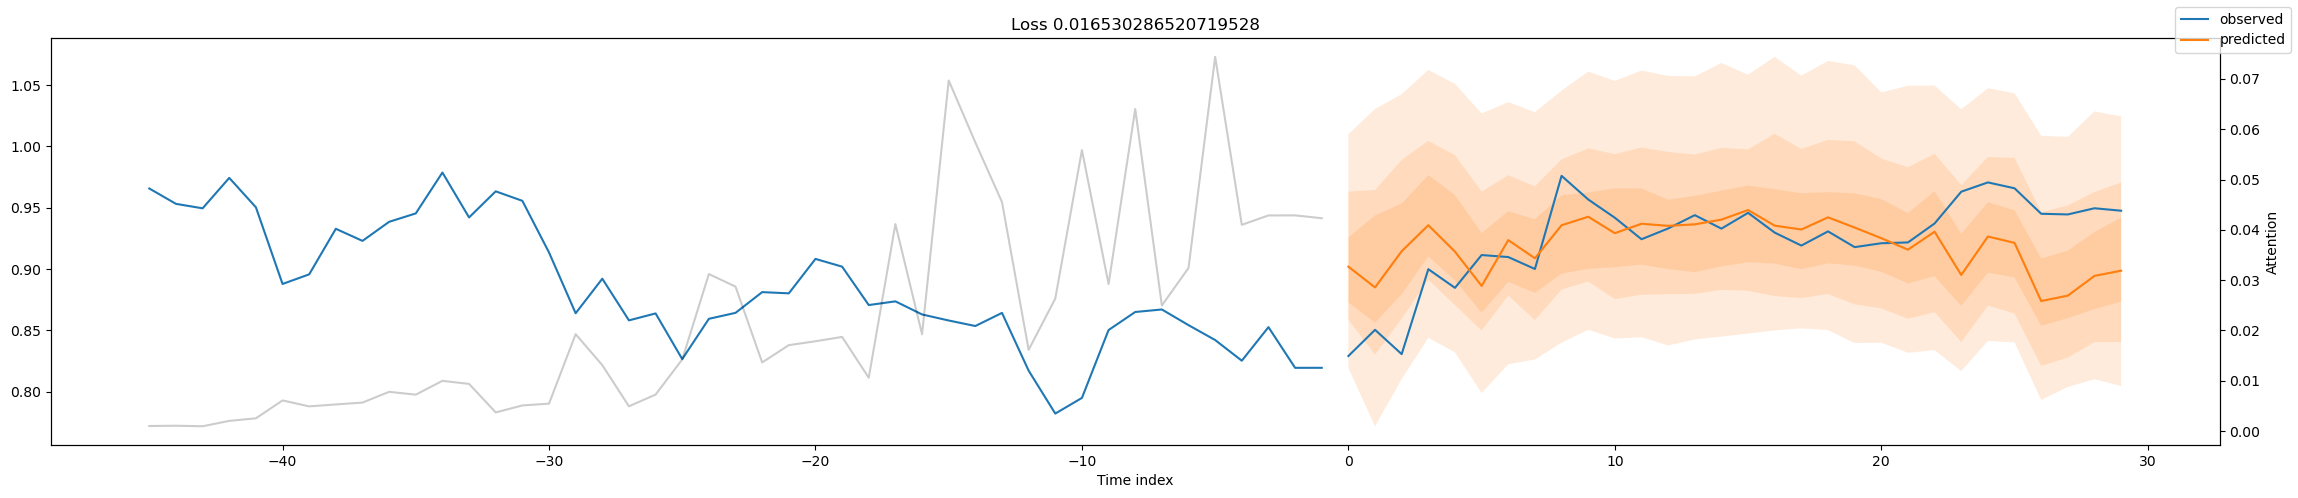

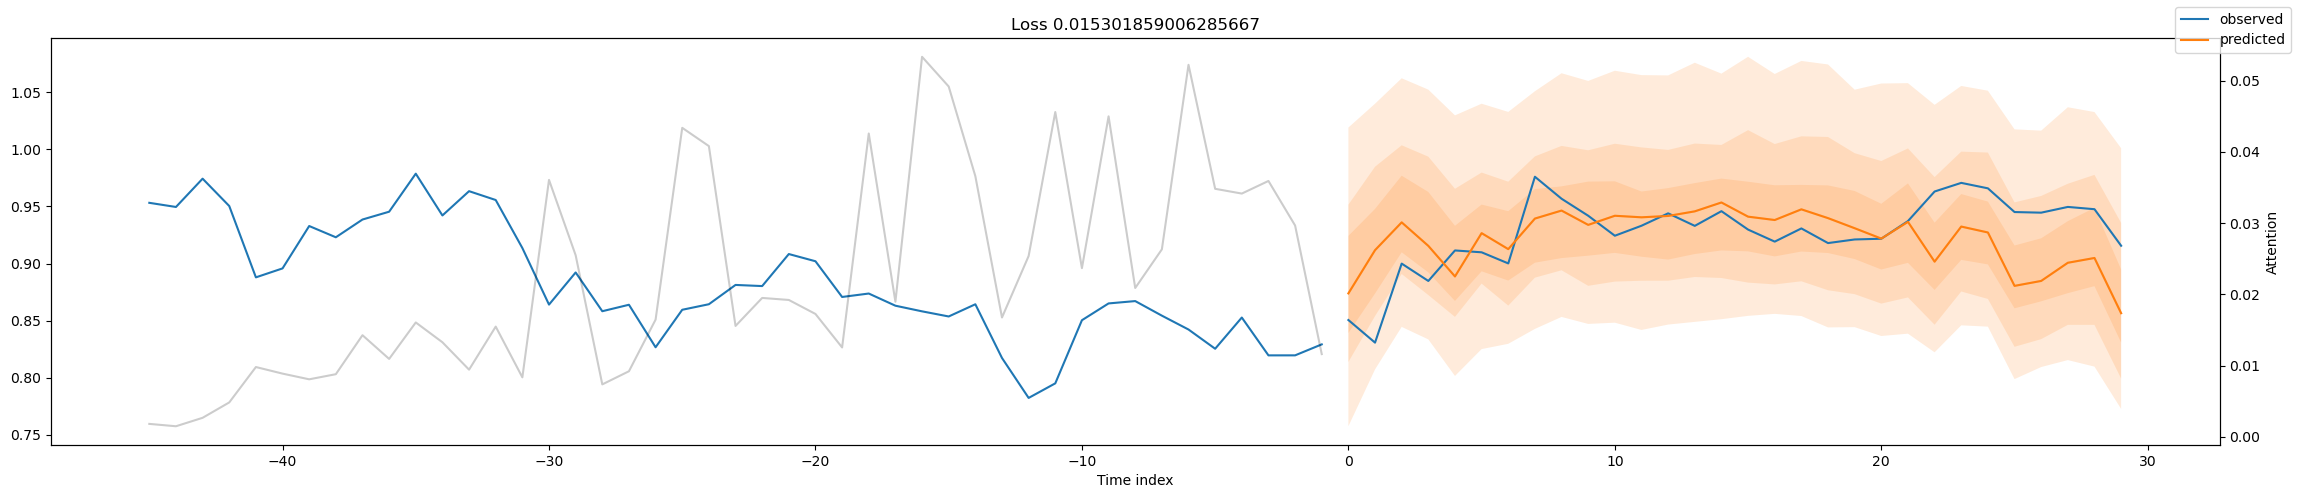

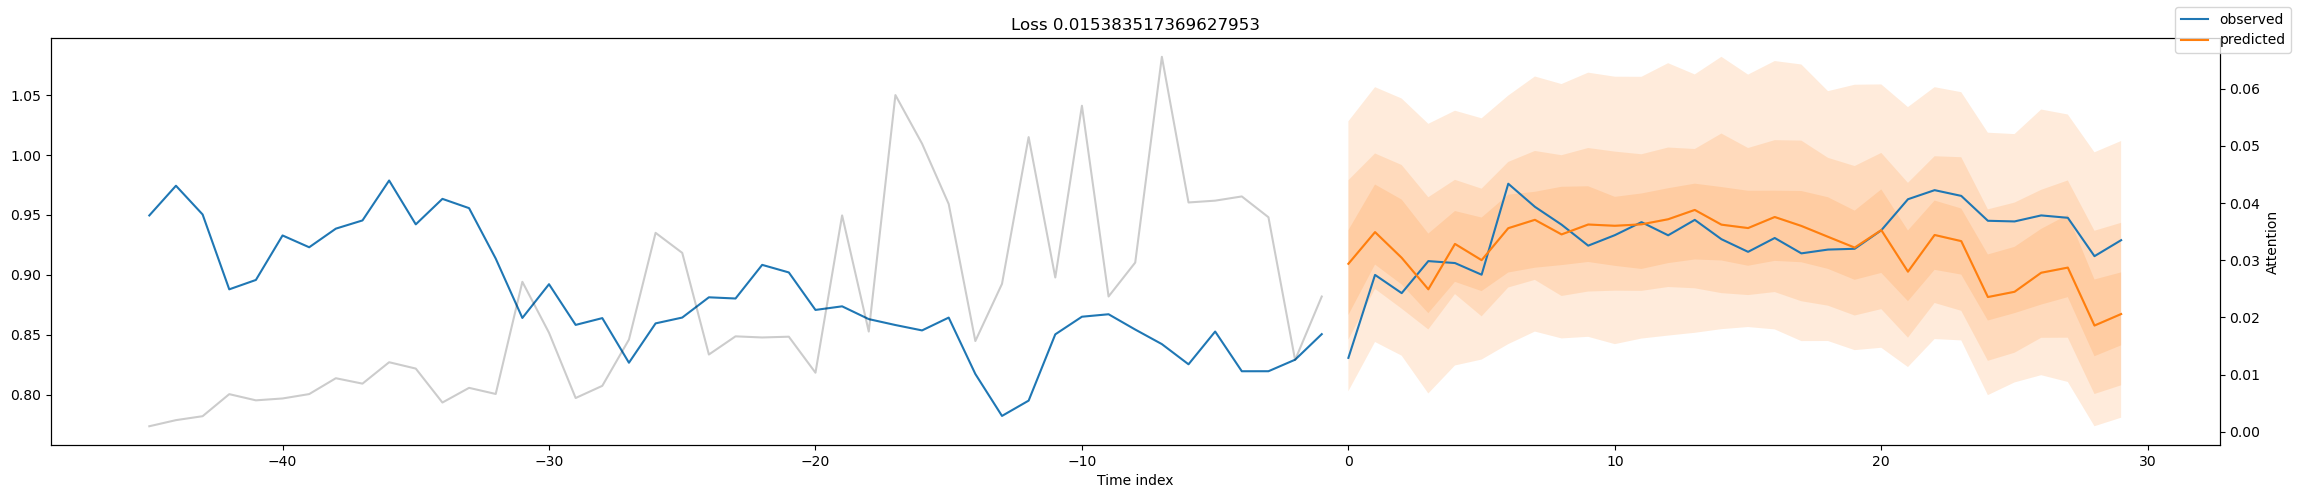

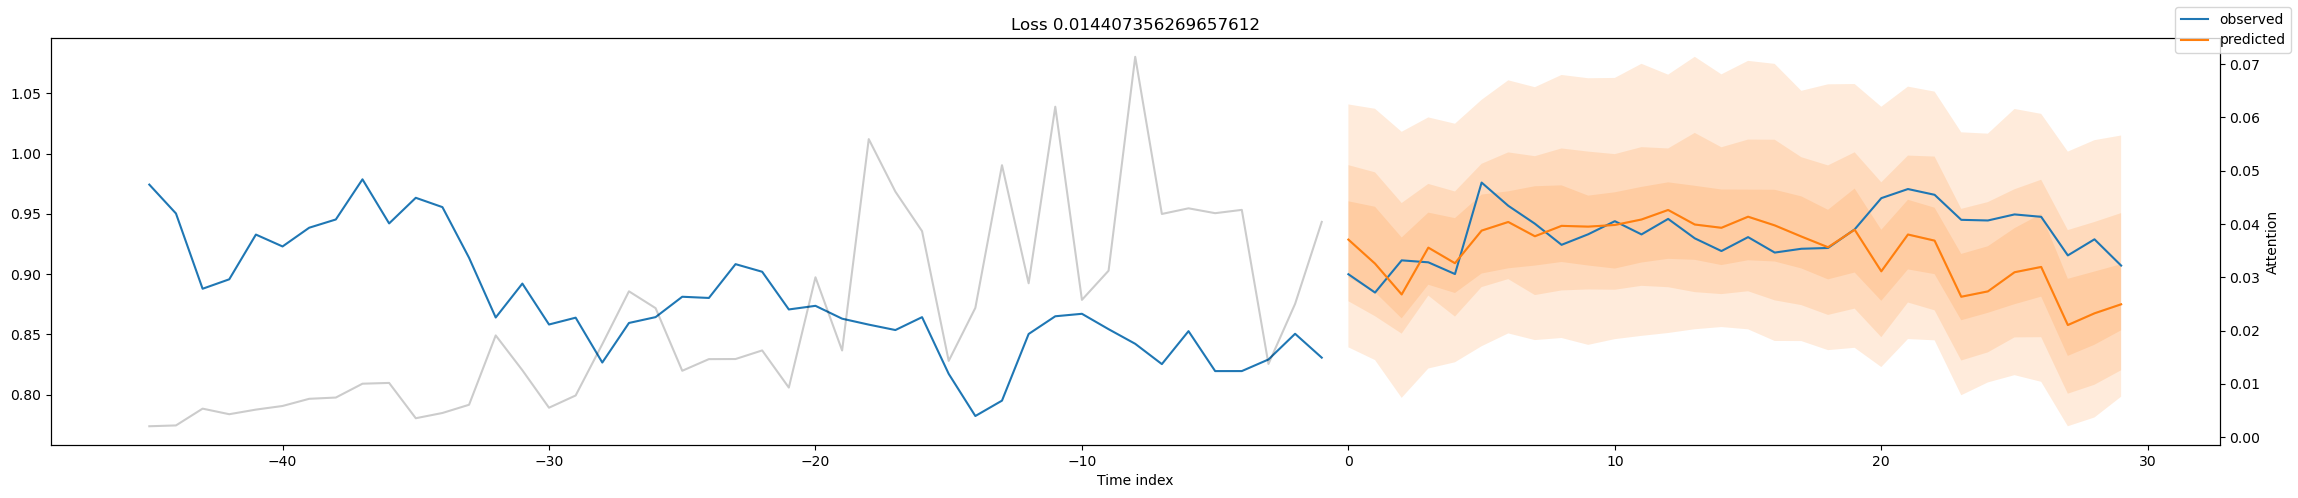

In [79]:
# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
from matplotlib import pyplot as plt


for idx in range(4):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE for BTC: 0.09148100763559341


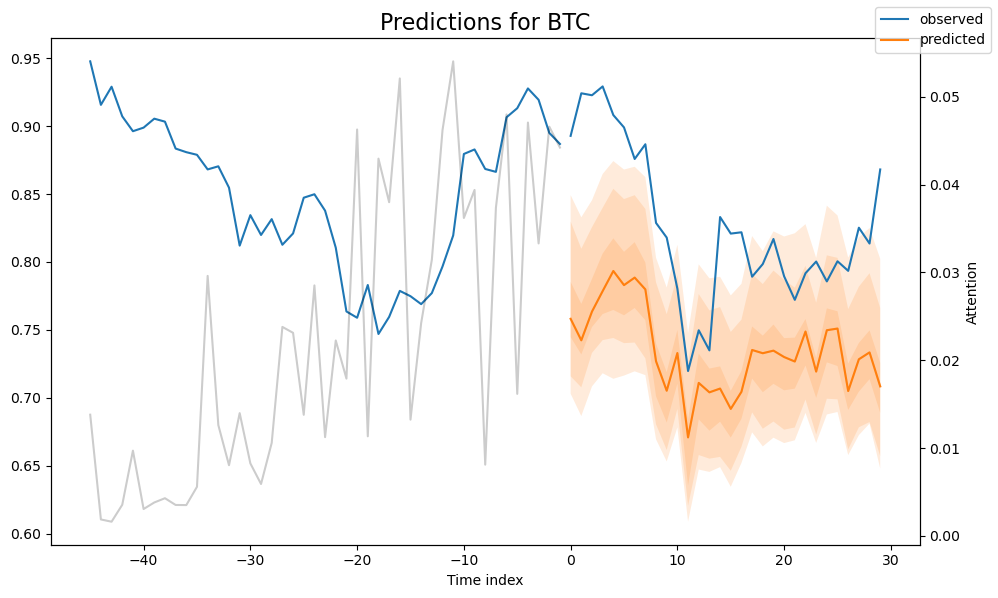

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE for ETH: 0.0414205938577652


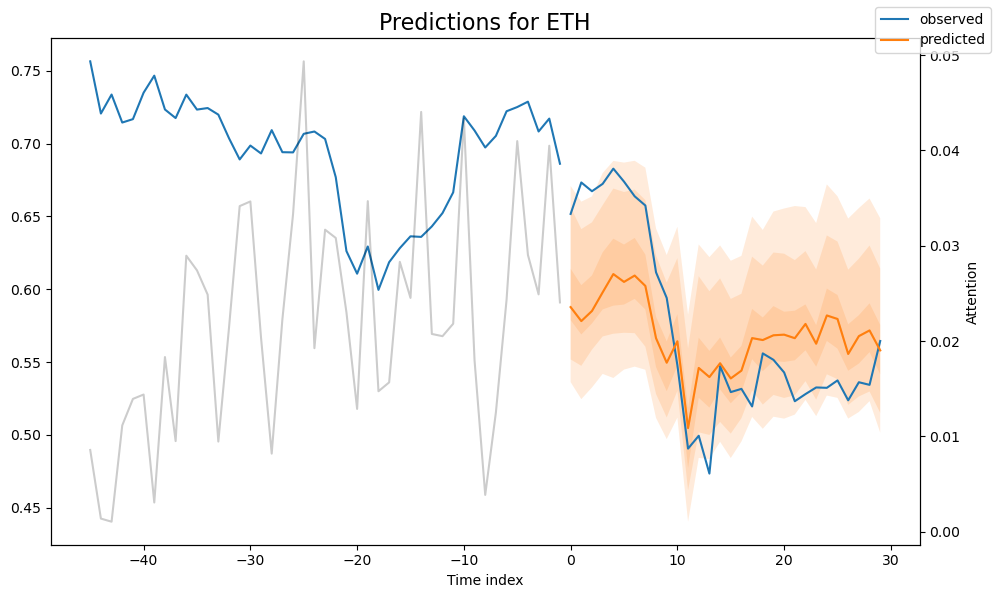

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE for LTC: 0.03264259174466133


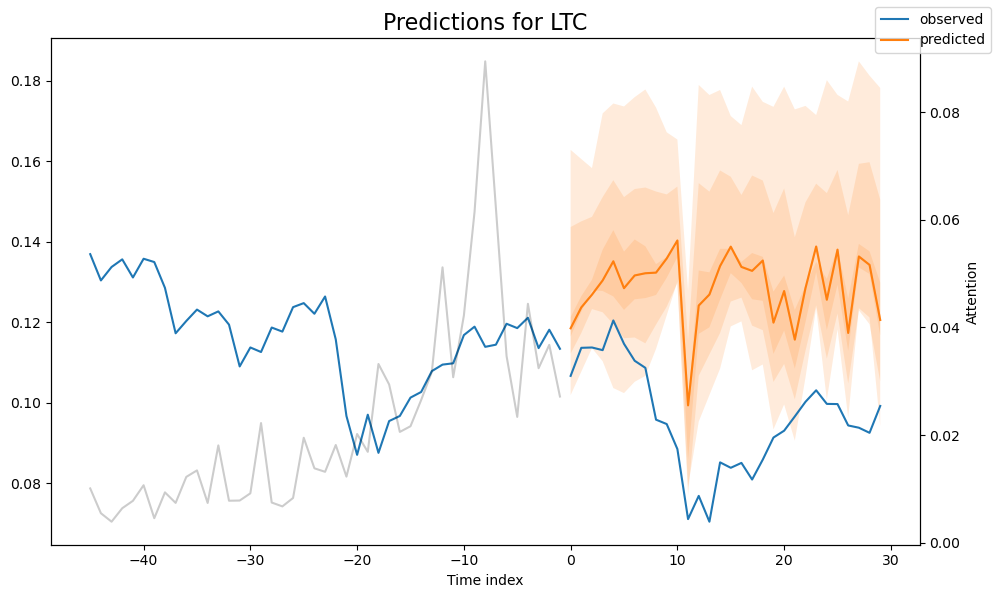

In [80]:
# Step 1: Get unique cryptocurrency types
cryptocurrencies = merged_data['currency_type'].unique()

# Step 2: Loop over each cryptocurrency and make predictions
for crypto in cryptocurrencies:
    # Filter data for the current cryptocurrency
    crypto_data = merged_data[merged_data['currency_type'] == crypto]
    prediction_dates = crypto_data['Date'].tail(max_prediction_length).values
    # Step 3: Create a DataLoader for the filtered cryptocurrency data
    crypto_val_dataloader = TimeSeriesDataSet.from_dataset(training, crypto_data, predict=True, stop_randomization=True).to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # Step 4: Make predictions for the current cryptocurrency
    predictions = best_tft.predict(crypto_val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))

    # Optionally, you can evaluate the predictions or plot them for each cryptocurrency
    # Evaluate MAE for this cryptocurrency (or any other metric)
    mae = MAE()(predictions.output, predictions.y)
    print(f"MAE for {crypto}: {mae.item()}")

    # Plot predictions for the first 10 samples (or any number you like)
    raw_predictions = best_tft.predict(crypto_val_dataloader, mode="raw", return_x=True)

    # Loop over the first 10 prediction samples
    for idx in range(min(10, raw_predictions.output.prediction.size(0))):  # Only plot available samples
        # Generate the plot
        fig, ax = plt.subplots(figsize=(10, 6))
        best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True, ax=ax)

        # Set custom title for the plot
        plot_title = f"Predictions for {crypto}"
        ax.set_title(plot_title, fontsize=16)

        # Show the plot
        plt.show()
